In [1]:
import re
import numpy as np
import math
import os
import random
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

In [4]:
#fetch from full dataframe 
BASE_DIR = '/home/hc3040/crypto_code_detection/data'
full_df=pd.read_json(BASE_DIR+'/full_data.json')
train_df=pd.read_json(BASE_DIR+'/train.json')
test_df=pd.read_json(BASE_DIR+'/test.json')

In [5]:
test_df

,data_source,label,file_name,is_header,content
0,others,0,usb_hub.h,True,#ifndef _USB_HUB_H_\n#define _USB_HUB_H_\n\n/*...
1,others,0,ngx_cache_purge_module.c,False,"/*\n * Copyright (c) 2009-2014, FRiCKLE <info@..."
2,others,0,SGitSourceControlSettings.h,True,// Copyright (c) 2014-2018 Sebastien Rombauts ...
3,code-jam_,0,code-jam_2433487_iwi_2860486_1_extracted_C.cpp,False,#include <iostream>\n#include <sstream>\n#incl...
4,code-jam_,0,code-jam_2984486_eax255_5634947029139456_0_ext...,False,#include <stdio.h>\n#include <iostream>\n#incl...
...,...,...,...,...,...
1608,code-jam_,0,code-jam_1645485_kasuistry_1480492_0_extracted...,False,\n#include <cstdio>\n\ndouble abs(double a){\n...
1609,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,True,"/* mini-gmp, a minimalistic implementation of ..."
1610,code-jam_,0,code-jam_1781488_sztrovacsek_1674486_0_extract...,False,#include <iostream>\n#include <vector>\n#inclu...
1611,code-jam_,0,code-jam_32013_filix_24479_0_extracted_c.cpp,False,#include<cstdio>\n#include<cmath>\nusing names...


In [119]:
train_df

,data_source,label,file_name,is_header,content
0,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* primegen.c - prime number generator\n * Cop...
1,others,0,c_impl.c,False,"#include <stdio.h>\n\nfloat f (char *str, int ..."
2,code-jam_,0,code-jam_3004486_MingBeta_5706278382862336_1_e...,False,#include <iostream>\n\nusing namespace std;\n\...
3,code-jam_,0,code-jam_8224486_geniucos_5769900270288896_0_e...,False,#include<cstdio>\n#include<vector>\n#include<c...
4,others,0,nat.h,True,#ifndef __NAT_H__\n#define __NAT_H__\n\nstruct...
...,...,...,...,...,...
9131,code-jam_,0,code-jam_2075486_SnapDragon_1821487_1_extracte...,False,#include <algorithm>\n#include <cmath>\n#inclu...
9132,others,0,ncamera.cc,False,#include <string>\n#include <utility>\n\n#incl...
9133,code-jam_,0,code-jam_32013_jbernadas_24479_0_extracted_sou...,False,"#include ""assert.h""\n#include ""ctype.h""\n#incl..."
9134,others,0,UpdateDialogGtk.cpp,False,"#include ""UpdateDialogGtk.h""\n\n#include ""AppI..."


In [13]:
BASE_DIR = "/home/hc3040/crypto_code_detection/data/"


crypto_library_df = pd.read_json(BASE_DIR + "crypto-library/crypto-library_data.json")
crypto_competitions_df = pd.read_json(BASE_DIR + "crypto-competitions/crypto-competitions_data.json")
code_jam_df = pd.read_json(BASE_DIR + "code-jam/code-jam_data.json")
others_df = pd.read_json(BASE_DIR + "others/others_data.json")

full_df = pd.concat([crypto_library_df, crypto_competitions_df, 
                     code_jam_df, others_df], 
                    ignore_index=True)

def transform_df(df): 
    """This transform the df formed with the json into the format we want, 
    which is file_name and content as two separate columns instead of being
    unites under data"""
    df['file_name'] = [df.data[i]['file_name'] for i in range(df.shape[0])]
    df['is_header'] = [df.file_name[i].split('.')[-1][0] == 'h' for i in range(df.shape[0])]
    df['content'] = [df.data[i]['content'] for i in range(df.shape[0])]
    df.drop('data', axis=1, inplace=True)
    return(df)
    
full_df = transform_df(full_df)

In [14]:
full_df

,data_source,label,file_name,is_header,content
0,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* eddsa-hash.c\n\n Copyright (C) 2014 Niels...
1,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* twofishdata.c\n\n Generates the permutati...
2,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* umac32.c\n\n Copyright (C) 2013 Niels Möl...
3,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,True,/* cfb.h\n\n Cipher feedback mode.\n\n Cop...
4,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,True,/* eddsa.h\n\n Copyright (C) 2014 Niels Möll...
...,...,...,...,...,...
10744,others,0,__math.h,True,/* Inline math functions for i387.\n Copyrig...
10745,others,0,__ocl_iterator.h,True,//\n// Copyright (c) 2015-2016 The Khronos Gro...
10746,others,0,暴力搜索_二维数组中查找.hpp,True,/*\n¶þÎ¬Êý×éÖÐ²éÕÒ https://www.nowcoder.com/pr...
10747,others,0,源.cpp,False,#include <iostream>\n#include <math.h>\n#inclu...


In [120]:
# X=full_df[['data_source', 'file_name', 'is_header', 'content']]
# Y=full_df[['label']]
# xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 0)

xTrain = train_df[['data_source', 'file_name', 'is_header', 'content']]
yTrain = train_df[['label']]
xTest= test_df[['data_source', 'file_name', 'is_header', 'content']]
yTest= test_df[['label']]

In [70]:
file = open('feature_tuple_list.txt','r') 
F=file.read()
feature_tuple_list=list(map(lambda x : tuple(x.split(';')), F.split('\n')))[:-1] #remove trailing line
feature_names=list(map(lambda x : x[0].strip() , feature_tuple_list))

In [71]:
feature_tuple_list

[('number of >> ', ' >>'),
 ('number of ^ ', ' \\^'),
 ('number of << ', ' <<'),
 ('number of mentions of key ', ' key'),
 ('number of mentions of encrypt ', ' encrypt'),
 ('number of mentions of decrypt ', ' decrypt'),
 ('number of mentions of prime ', ' prime'),
 ('number of mentions of (a)symmetric ', ' symmetric'),
 ('number of mentions of cipher ', ' cipher'),
 ('number of mentions of crypto ', ' crypto'),
 ('number of mentions of password ', ' password'),
 ('nb of pwd ', ' pwd'),
 ('number of mentions of bits ', ' bits'),
 ('nb of byte ', ' byte'),
 ('number of mentions of generator ', ' generator'),
 ('number of mentions of hash ', ' hash'),
 ('number of mentions of salt ', ' salt'),
 ('number of mentions of garlic ', ' garlic'),
 ('nb of rsa ', ' rsa'),
 ('nb of signature ', ' signature'),
 ('nb of sign ', ' sign'),
 ('nb of block ', ' block'),
 ('nb of congruent ', ' congruent'),
 ('nb of shuffle ', ' shuffle'),
 ('nb of xor ', ' xor '),
 ('nb of permutation ', ' permutation')

In [95]:
def build_vector(row,feature_tuple_list=None,normalize=False):
    if feature_tuple_list is None :
        file = open('feature_tuple_list.txt','r') 
        F=file.read()
        feature_tuple_list=list(map(lambda x : tuple(x.split(';')), F.split('\n')))[:-1] #remove trailing line
    list_of_lines=row[3].split('\n')
    feature_counts=[0]*len(feature_tuple_list)
    feature_list=[f[1] for f in feature_tuple_list]
    for line in list_of_lines : 
        for i,f in enumerate(feature_list) :
            #need to strip to remove spaces + lowercase to match on our lowercase expression
            if re.search(f.strip(), line.lower()) : feature_counts[i]+=len(re.findall(f.strip(), line.lower()))
    if normalize : return list(np.array(feature_counts)/(max(np.sum(np.array(feature_counts)),1)))
    else : return feature_counts

In [18]:
sum(yTrain['label'])

1048

In [121]:
xTrain_vec=xTrain.apply(lambda row: build_vector(row), axis=1)
xTrain_vec_df=xTrain_vec.to_frame()
xTrain_vec_df.columns=['vec']
xTrain_vec_df=xTrain_vec_df.vec.apply(pd.Series)
xTrain_vec_df.columns=feature_names
#for xgboost :
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
xTrain_vec_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in xTrain_vec_df.columns.values]

In [75]:
xTrain_vec_df

,number of >>,number of ^,number of __,number of mentions of key,number of mentions of encrypt,number of mentions of decrypt,number of mentions of prime,number of mentions of (a)symmetric,number of mentions of cipher,number of mentions of crypto,...,library import of cryptolib,library import of openssl,library import of gnutls,library import of cryptlib,library import of gcrypt,library import of sodium,library import of nettle,library import of nss,library import of wolfssl,library import of mbedtls
4549,0.500000,0.0,0.277778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3910,0.473684,0.0,0.263158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6747,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1427,0.166667,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6925,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4859,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3264,0.032258,0.0,0.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def modelfit(alg, xTrain_vec_df, yTrain,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xTrain_vec_df, label=yTrain.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
          metrics='merror', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xTrain_vec_df, yTrain,eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(xTrain_vec_df)
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(yTrain, dtrain_predictions))                   
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [27]:
params = { "n_estimators": 400, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }

model = XGBClassifier(**params)

In [32]:
model=XGBClassifier(learning_rate=0.2, gamma=0, subsample=0.8,tree_method='gpu_hist',n_gpu=-1,n_estimators = 400,
 objective= 'gpu:binary:logistic', scale_pos_weight=int((len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])), seed=0)

In [33]:
model.fit(xTrain_vec_df, yTrain)

[21:34:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:170: gpu:binary:logistic is now deprecated, use binary:logistic instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_gpu=-1,
              n_jobs=1, nthread=None, objective='gpu:binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=7,
              seed=0, silent=None, subsample=0.8, tree_method='gpu_hist',
              verbosity=1)

In [122]:
#1 : find the number of trees
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators': [200],
 'learning_rate' : list(10**(-np.arange(30)/10)),
# # 'subsample' : list(np.arange(0.5,1,0.1)),
#  'colsample_bytree' : list(np.arange(0.5,1,0.1))   
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(gamma=0, subsample=0.8,
 objective= 'binary:logistic', scale_pos_weight=int((len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])), seed=0), 
 param_grid = param_test1, scoring='recall',iid=True, n_jobs=-1, cv=5, verbose=2)
gsearch1.fit(xTrain_vec_df, yTrain)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  2.0min finished
/home/hc3040/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hc3040/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                           0.007943282347242814,
                                           0.00630957344480193,
                                           0.005011872336272725,
                                           0.003981071705534973,
                                           0.0031622776601683794,
                              

In [77]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.025118864315095794, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=0,
              silent=None, subsample=0.8, verbosity=1)

In [123]:
res=pd.DataFrame.from_dict(gsearch1.cv_results_)

In [124]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.341296,0.322077,0.018467,0.000702,1,3,1,200,"{'learning_rate': 1.0, 'max_depth': 3, 'min_ch...",0.867580,0.844037,0.876147,0.857798,0.857798,0.860673,0.010774,306
1,3.441556,0.122952,0.018679,0.000669,1,3,3,200,"{'learning_rate': 1.0, 'max_depth': 3, 'min_ch...",0.922374,0.839450,0.871560,0.876147,0.857798,0.873471,0.027591,262
2,3.471857,0.221630,0.018272,0.000503,1,3,5,200,"{'learning_rate': 1.0, 'max_depth': 3, 'min_ch...",0.890411,0.825688,0.880734,0.894495,0.839450,0.866158,0.028124,298
3,5.272822,0.247650,0.025087,0.000768,1,5,1,200,"{'learning_rate': 1.0, 'max_depth': 5, 'min_ch...",0.872146,0.848624,0.880734,0.862385,0.821101,0.857000,0.020883,310
4,5.336013,0.210044,0.024756,0.000622,1,5,3,200,"{'learning_rate': 1.0, 'max_depth': 5, 'min_ch...",0.885845,0.830275,0.866972,0.862385,0.825688,0.854237,0.022878,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,5.595227,0.210920,0.017146,0.000423,0.00125893,7,3,200,"{'learning_rate': 0.0012589254117941675, 'max_...",0.858447,0.866972,0.885321,0.876147,0.857798,0.868936,0.010568,283
356,5.463043,0.172834,0.016405,0.000462,0.00125893,7,5,200,"{'learning_rate': 0.0012589254117941675, 'max_...",0.858447,0.866972,0.885321,0.880734,0.857798,0.869853,0.011326,277
357,6.446715,0.129629,0.019124,0.000676,0.00125893,9,1,200,"{'learning_rate': 0.0012589254117941675, 'max_...",0.867580,0.862385,0.894495,0.894495,0.853211,0.874433,0.017014,253
358,6.279804,0.153598,0.018507,0.000620,0.00125893,9,3,200,"{'learning_rate': 0.0012589254117941675, 'max_...",0.872146,0.866972,0.894495,0.899083,0.871560,0.880850,0.013215,227


In [100]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_dict = xgb.get_booster().get_fscore()
    total = sum([i for i in imp_dict.values()])
    return {k: (float(v)/total) for (k,v) in list(imp_dict.items())}

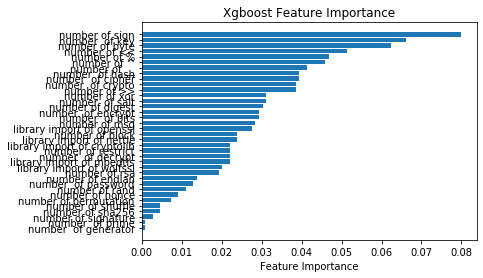

<Figure size 432x288 with 0 Axes>

In [101]:
import matplotlib.pyplot as plt

data=[(k,v) for k,v in get_xgb_imp(gsearch1.best_estimator_,feature_names).items()]
data=sorted(data,key=lambda x : -x[1])
names = [x[0] for x in data]
names[3]='number of <<'
names=list(map(lambda x  : x.replace('of mentions','').replace('nb','number of').replace('of of','of'),names))
values = [x[1] for x in data]
fig, ax = plt.subplots()
y_pos=np.arange(len(names))
                
ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Xgboost Feature Importance')

plt.show()
plt.savefig('feature_importance.png')
#tick_label does the some work as plt.xticks()
# plt.bar(range(len(data)),values,tick_label=names)
# plt.savefig('bar.png')
# plt.show()

In [114]:
values

[0.0798165137614679,
 0.06605504587155964,
 0.062385321100917435,
 0.05137614678899083,
 0.046788990825688076,
 0.045871559633027525,
 0.04128440366972477,
 0.03944954128440367,
 0.03944954128440367,
 0.03853211009174312,
 0.03853211009174312,
 0.031192660550458717,
 0.031192660550458717,
 0.030275229357798167,
 0.029357798165137616,
 0.029357798165137616,
 0.028440366972477066,
 0.027522935779816515,
 0.023853211009174313,
 0.023853211009174313,
 0.022018348623853212,
 0.022018348623853212,
 0.022018348623853212,
 0.022018348623853212,
 0.02018348623853211,
 0.01926605504587156,
 0.013761467889908258,
 0.012844036697247707,
 0.011009174311926606,
 0.009174311926605505,
 0.007339449541284404,
 0.0045871559633027525,
 0.0045871559633027525,
 0.0027522935779816515,
 0.0009174311926605505,
 0.0009174311926605505]

In [115]:
names

['number of sign',
 'number  of key',
 'number of byte',
 'number of <<',
 'number of %',
 'number of ^',
 'number of __',
 'number  of hash',
 'number  of cipher',
 'number  of crypto',
 'number of >>',
 'number of xor',
 'number  of salt',
 'number of digest',
 'number  of encrypt',
 'number  of bits',
 'number of msg',
 'library import of openssl',
 'number of block',
 'library import of nettle',
 'library import of cryptolib',
 'number of restrict',
 'number  of decrypt',
 'library import of mbedtls',
 'library import of wolfssl',
 'number of rsa',
 'number of endian',
 'number  of password',
 'number of rand',
 'number of nonce',
 'number of permutation',
 'number of shuffle',
 'number of sha256',
 'number of signature',
 'number  of prime',
 'number  of generator']

In [90]:
# now we know that 130 trees are optima, we will tune tree sepecific hyper parameters like max_depth and min_child_weight
#1 : find the number of trees
param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
         #'n_estimators': range(80,200,5),
        #  'eta' : list(np.arange(0.01,0.2,0.02)),
        # # 'subsample' : list(np.arange(0.5,1,0.1)),
        #  'colsample_bytree' : list(np.arange(0.5,1,0.1))   
        }
def CV_xgb_dict(param_test) : 
        gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate=0.2, gamma=0, subsample=0.8,n_estimators=130,
         objective= 'binary:logistic',nthread=48, scale_pos_weight=int((len(yTrain)-sum(yTrain['label'])) / sum(yTrain['label'])), seed=0), 
         param_grid = param_test, scoring='recall',iid=True, n_jobs=-1, cv=5, verbose=2)
        gsearch.fit(xTrain_vec_df, yTrain)
        return gsearch
    
CV_xgb_dict(param_test)    

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:  1.5min remaining:   33.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished
/home/hc3040/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hc3040/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=130, n_jobs=1,
                                     nthread=48, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=7, seed=0, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=True, n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [18]:
model = XGBClassifier()
model.fit(xTrain_vec_df, yTrain)

C:\Users\hadri\AppData\Local\Continuum\anaconda3\envs\quant_374\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hadri\AppData\Local\Continuum\anaconda3\envs\quant_374\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [80]:
model=gsearch1.best_estimator_

In [15]:
def test_and_evaluate(model) :
            xTest_vec=xTest.apply(lambda row: build_vector(row), axis=1)
            xTest_vec_df=xTest_vec.to_frame()
            xTest_vec_df.columns=['vec']
            xTest_vec_df=xTest_vec_df.vec.apply(pd.Series)
            xTest_vec_df.columns=feature_names
            #for xgboost :
            regex = re.compile(r"\[|\]|<", re.IGNORECASE)
            xTest_vec_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in xTest_vec_df.columns.values]

            yPred = model.predict(xTest_vec_df)
            M=confusion_matrix(yTest,yPred.reshape(np.array(yTest).shape))
            print('confusion matrix : ')
            print('               ')
            print('      predicted value')
            print('actual', list(M[0]))
            print('value ', list(M[1]))
            print('              ')
            print('Recall for positives = TP/(TP+FN) = ' + str(round(100*M[1][1]/(M[1][1]+M[1][0]),2)) + '%' + ' = ' + 'Conditional probability that we output 1 when the file is indeed crypto')
            print('Recall for negatives = TN/(TN+FP) = '+ str(round(100*M[0][0]/(M[0][0]+M[0][1]),2)) + '%')
            print('Precision for both classes = (TP+TN)/(all) = ' + str(round(100*(M[1][1]+M[0][0])/(sum([M[i][j] for i in [0,1] for j in [0,1]])),2)) + '%')

In [17]:
import joblib

filename='89-96-double_reg_xgbmodel.joblib'
filename2='86-96_xgbmodel.joblib'
#save model
#joblib.dump(model, "86-96_xgbmodel.joblib") 

 #load saved model
xgb = joblib.load(filename)
model2=joblib.load(filename2)

[18:48:22] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:170: gpu:binary:logistic is now deprecated, use binary:logistic instead.
[18:48:22] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:170: gpu:binary:logistic is now deprecated, use binary:logistic instead.


In [24]:
test_and_evaluate(gsearch1.best_estimator_)

confusion matrix : 
               
      predicted value
actual [1862, 52]
value  [33, 203]
              
Recall for positives = TP/(TP+FN) = 86.02% = Conditional probability that we output 1 when the file is indeed crypto
Recall for negatives = TN/(TN+FP) = 97.28%
Precision for both classes = (TP+TN)/(all) = 96.05%


In [125]:
model=gsearch1.best_estimator_

xTest_vec=xTest.apply(lambda row: build_vector(row), axis=1)
xTest_vec_df=xTest_vec.to_frame()
xTest_vec_df.columns=['vec']
xTest_vec_df=xTest_vec_df.vec.apply(pd.Series)
xTest_vec_df.columns=feature_names
#for xgboost :
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
xTest_vec_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in xTest_vec_df.columns.values]

yPred = model.predict(xTest_vec_df)
M=confusion_matrix(yTest,yPred.reshape(np.array(yTest).shape))
TP=M[1][1]
TN=M[0][0]
FN=M[1][0]
FP=M[0][1]
P=TP/(TP+FP)
R=TP/(TP+FN)
print('confusion matrix : ')
print('               ')
print('      predicted value')
print('actual', list(M[0]))
print('value ', list(M[1]))
print('              ')
print('Recall for positives = TP/(TP+FN) = ' + str(round(100*M[1][1]/(M[1][1]+M[1][0]),2)) + '%' + ' = ' + 'Conditional probability that we output 1 when the file is indeed crypto')
print('Recall for negatives = TN/(TN+FP) = '+ str(round(100*M[0][0]/(M[0][0]+M[0][1]),2)) + '%')
print('Precision for both classes = (TP+TN)/(all) = ' + str(round(100*(M[1][1]+M[0][0])/(sum([M[i][j] for i in [0,1] for j in [0,1]])),2)) + '%')
print('F2 score = 5*P*R/(4*P+R) = ' + str(5*P*R/(4*P+R)))

confusion matrix : 
               
      predicted value
actual [1377, 43]
value  [22, 171]
              
Recall for positives = TP/(TP+FN) = 88.6% = Conditional probability that we output 1 when the file is indeed crypto
Recall for negatives = TN/(TN+FP) = 96.97%
Precision for both classes = (TP+TN)/(all) = 95.97%
F2 score = 5*P*R/(4*P+R) = 0.8671399594320489


In [126]:
joblib.dump(gsearch1.best_estimator_,'F2_867_xgbmodel.joblib')

['F2_867_xgbmodel.joblib']

In [83]:
import copy

In [127]:
xTest_with_labels=copy.deepcopy(xTest)

In [128]:
xTest_with_labels['true_label']=yTest

In [129]:
xTest_with_labels['pred_label']=yPred

In [130]:
xTest_with_labels

,data_source,file_name,is_header,content,true_label,pred_label
0,others,usb_hub.h,True,#ifndef _USB_HUB_H_\n#define _USB_HUB_H_\n\n/*...,0,0
1,others,ngx_cache_purge_module.c,False,"/*\n * Copyright (c) 2009-2014, FRiCKLE <info@...",0,1
2,others,SGitSourceControlSettings.h,True,// Copyright (c) 2014-2018 Sebastien Rombauts ...,0,0
3,code-jam_,code-jam_2433487_iwi_2860486_1_extracted_C.cpp,False,#include <iostream>\n#include <sstream>\n#incl...,0,0
4,code-jam_,code-jam_2984486_eax255_5634947029139456_0_ext...,False,#include <stdio.h>\n#include <iostream>\n#incl...,0,0
...,...,...,...,...,...,...
1608,code-jam_,code-jam_1645485_kasuistry_1480492_0_extracted...,False,\n#include <cstdio>\n\ndouble abs(double a){\n...,0,0
1609,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,True,"/* mini-gmp, a minimalistic implementation of ...",1,0
1610,code-jam_,code-jam_1781488_sztrovacsek_1674486_0_extract...,False,#include <iostream>\n#include <vector>\n#inclu...,0,0
1611,code-jam_,code-jam_32013_filix_24479_0_extracted_c.cpp,False,#include<cstdio>\n#include<cmath>\nusing names...,0,0


In [131]:
xTest_with_labels_T=xTest_with_labels[xTest_with_labels.true_label==1]

In [132]:
FN_df=xTest_with_labels_T[xTest_with_labels_T.pred_label==0]

In [133]:
FN_df.to_csv('FN_F2_867.csv')

In [134]:
FN_df

,data_source,file_name,is_header,content,true_label,pred_label
136,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,False,/* pkcs1-sec-decrypt.c\n\n The RSA publickey...,1,0
140,crypto-competitions,cubehash.h,True,#ifndef CUBEHASH_H\n#define CUBEHASH_H\n\n#inc...,1,0
151,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,True,#ifndef ladder_base_H\n#define ladder_base_H\n...,1,0
154,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,True,"{ /* 0/31 */\n {\n { 25967493, -14356035, ...",1,0
257,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,False,/* umac-poly64.c\n\n Copyright (C) 2013 Niel...,1,0
275,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,False,/*\n * Copyright 2017-2019 The OpenSSL Project...,1,0
299,crypto-competitions,catena-blake2b.c,False,"#include ""catena.h""\n#include ""blake2.h""\n#inc...",1,0
523,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,True,/* memops.h\n\n Copyright (C) 2016 Niels Möl...,1,0
542,crypto-competitions,util.h,True,/*\nutil.h - Utility functions\nWritten in 201...,1,0
679,crypto-library,/Users/red/Documents/CP/crypto_code_detection/...,False,/* ecc-scalar.c\n\n Copyright (C) 2013 Niels...,1,0


In [135]:
FN_df.groupby('data_source').count()

,file_name,is_header,content,true_label,pred_label
data_source,,,,,
crypto-competitions,5,5,5,5,5
crypto-library,17,17,17,17,17


In [136]:
FN_df_fn=list(FN_df['file_name'])

In [137]:
FN_df_fn

['/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/nettle/pkcs1-sec-decrypt.c',
 'cubehash.h',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/libsodium/crypto_scalarmult/curve25519/sandy2x/ladder_base.h',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/libsodium/crypto_core/ed25519/ref10/fe_25_5/base.h',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/nettle/umac-poly64.c',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/open_ssl/sha/sha3.c',
 'catena-blake2b.c',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/nettle/memops.h',
 'util.h',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/nettle/ecc-scalar.c',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/nettle/ecc-mul-a-eh.c',
 'tiaoxin-optimized.h',
 '/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/nettle/ca

In [118]:
#findings :

#picked F2 as unique number evaluation metric to speed up the research
#based on error analysis I added the coarse features sign, %, hexadecimals, block and msg
#sign (1/48) and % (5/48) and hexa (8/48) ended up really important 
#normalizing is slighlty worse than not normalizing
#80% of FN come from library files, most of them from nettle and libsodium
#very difficult to extract ast from C code because it requires compilation, there is no good API, it would require intimate knowledge of C/C++ compilers and some files are just "broken" in the dataset 
#It is much easier to extract ASTs from java, C# or python
#best bet is through language agnostic transformer model like http://github.com/tech-srl/code2seq

#now by using the corrected test and train df and not normalizing and with new features : 
#went from f2= 0.864 -> 0.867 very slight improvement 
